<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Transformations</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy
from scipy import stats

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

numpy     1.18.1
json      2.0.9
scipy     1.4.1
autopep8  1.5
watermark 2.0.2
pandas    1.0.1
Thu Mar 05 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : e9953424c2f06ff0260f07f5a62a740e57c70a5b


Set the default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

In this notebook we illustrate several of the typical transformations and data manipulations that are common in time series analysis. Let's start by loading the Dow-Jones Industrial Average dataset

Text(0.5, 0, 'Date')

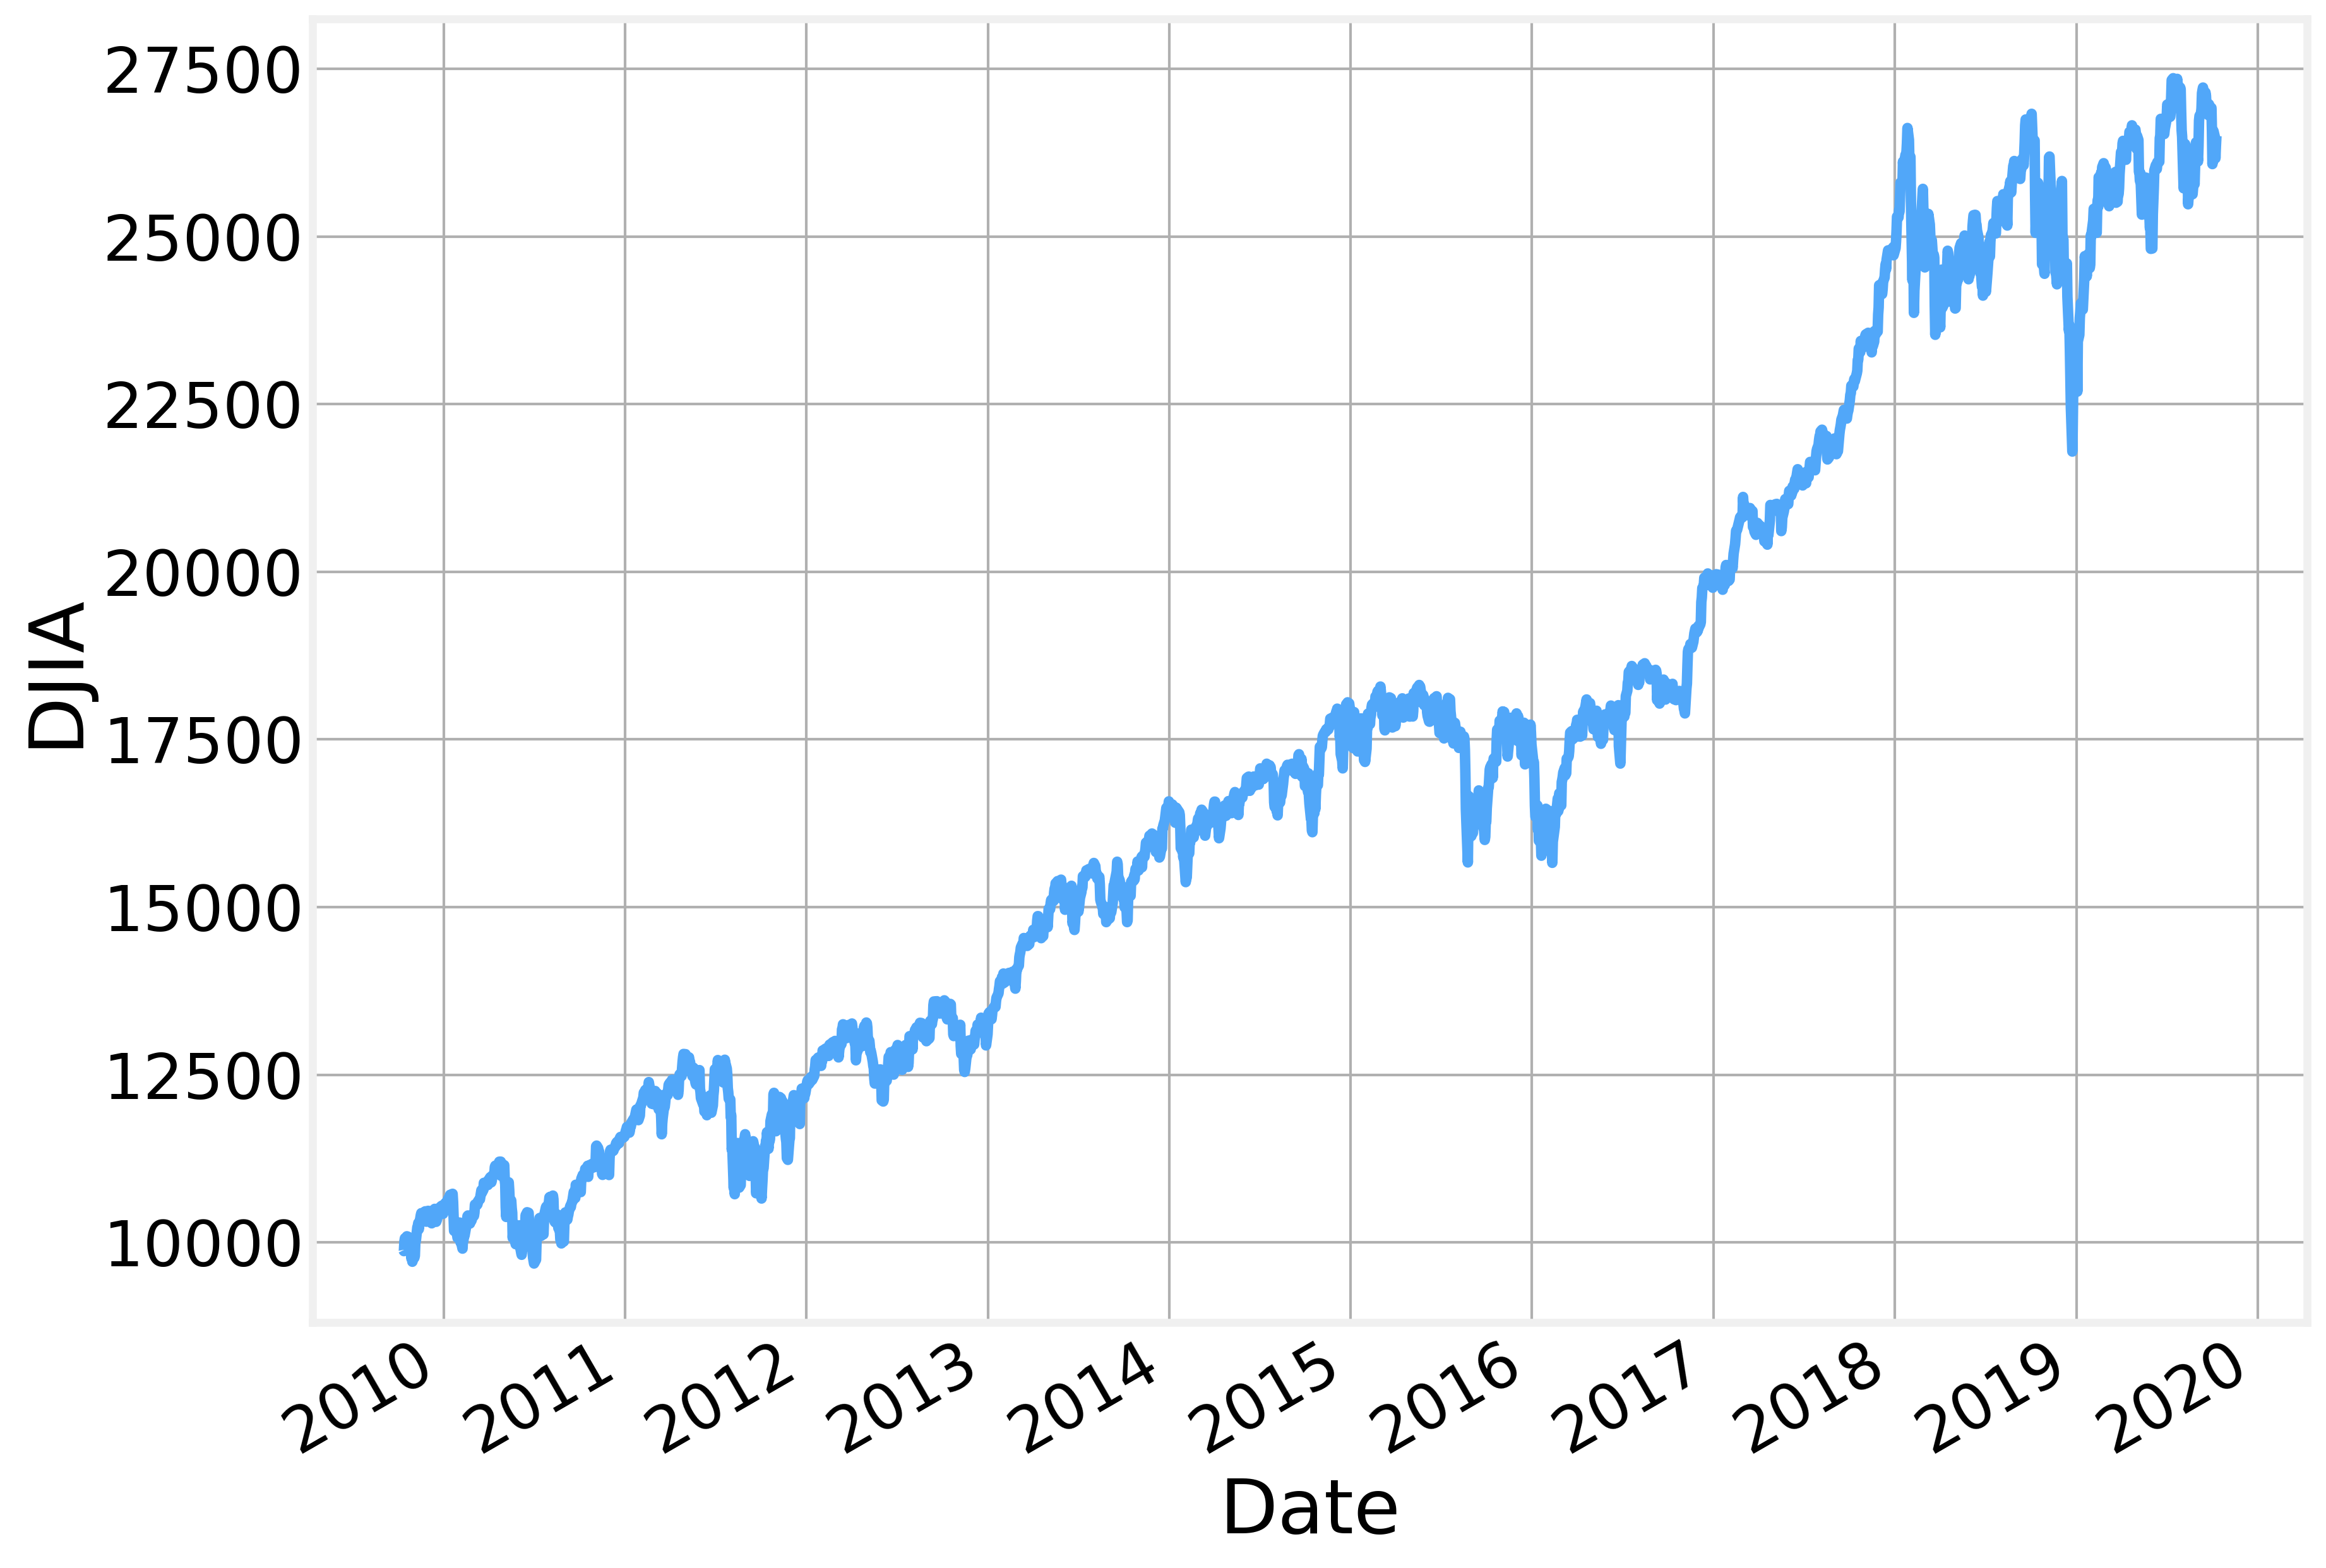

In [4]:
DJIA = pd.read_csv('data/DJIA.csv', parse_dates=['DATE'], na_values='.').dropna()
DJIA.set_index('DATE', inplace=True)
DJIA.plot(legend=False)
ax = plt.gca()
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')

## Lagged Values

The pandas method __shift(lag)__ allows us to quickly calculate lagged values for any Series. For positive values of __lag__ it pushes current values __lag__ steps into the future, while for negative values is moves them into the past

Let's look at a subset of the data

Text(0.5, 0, 'Date')

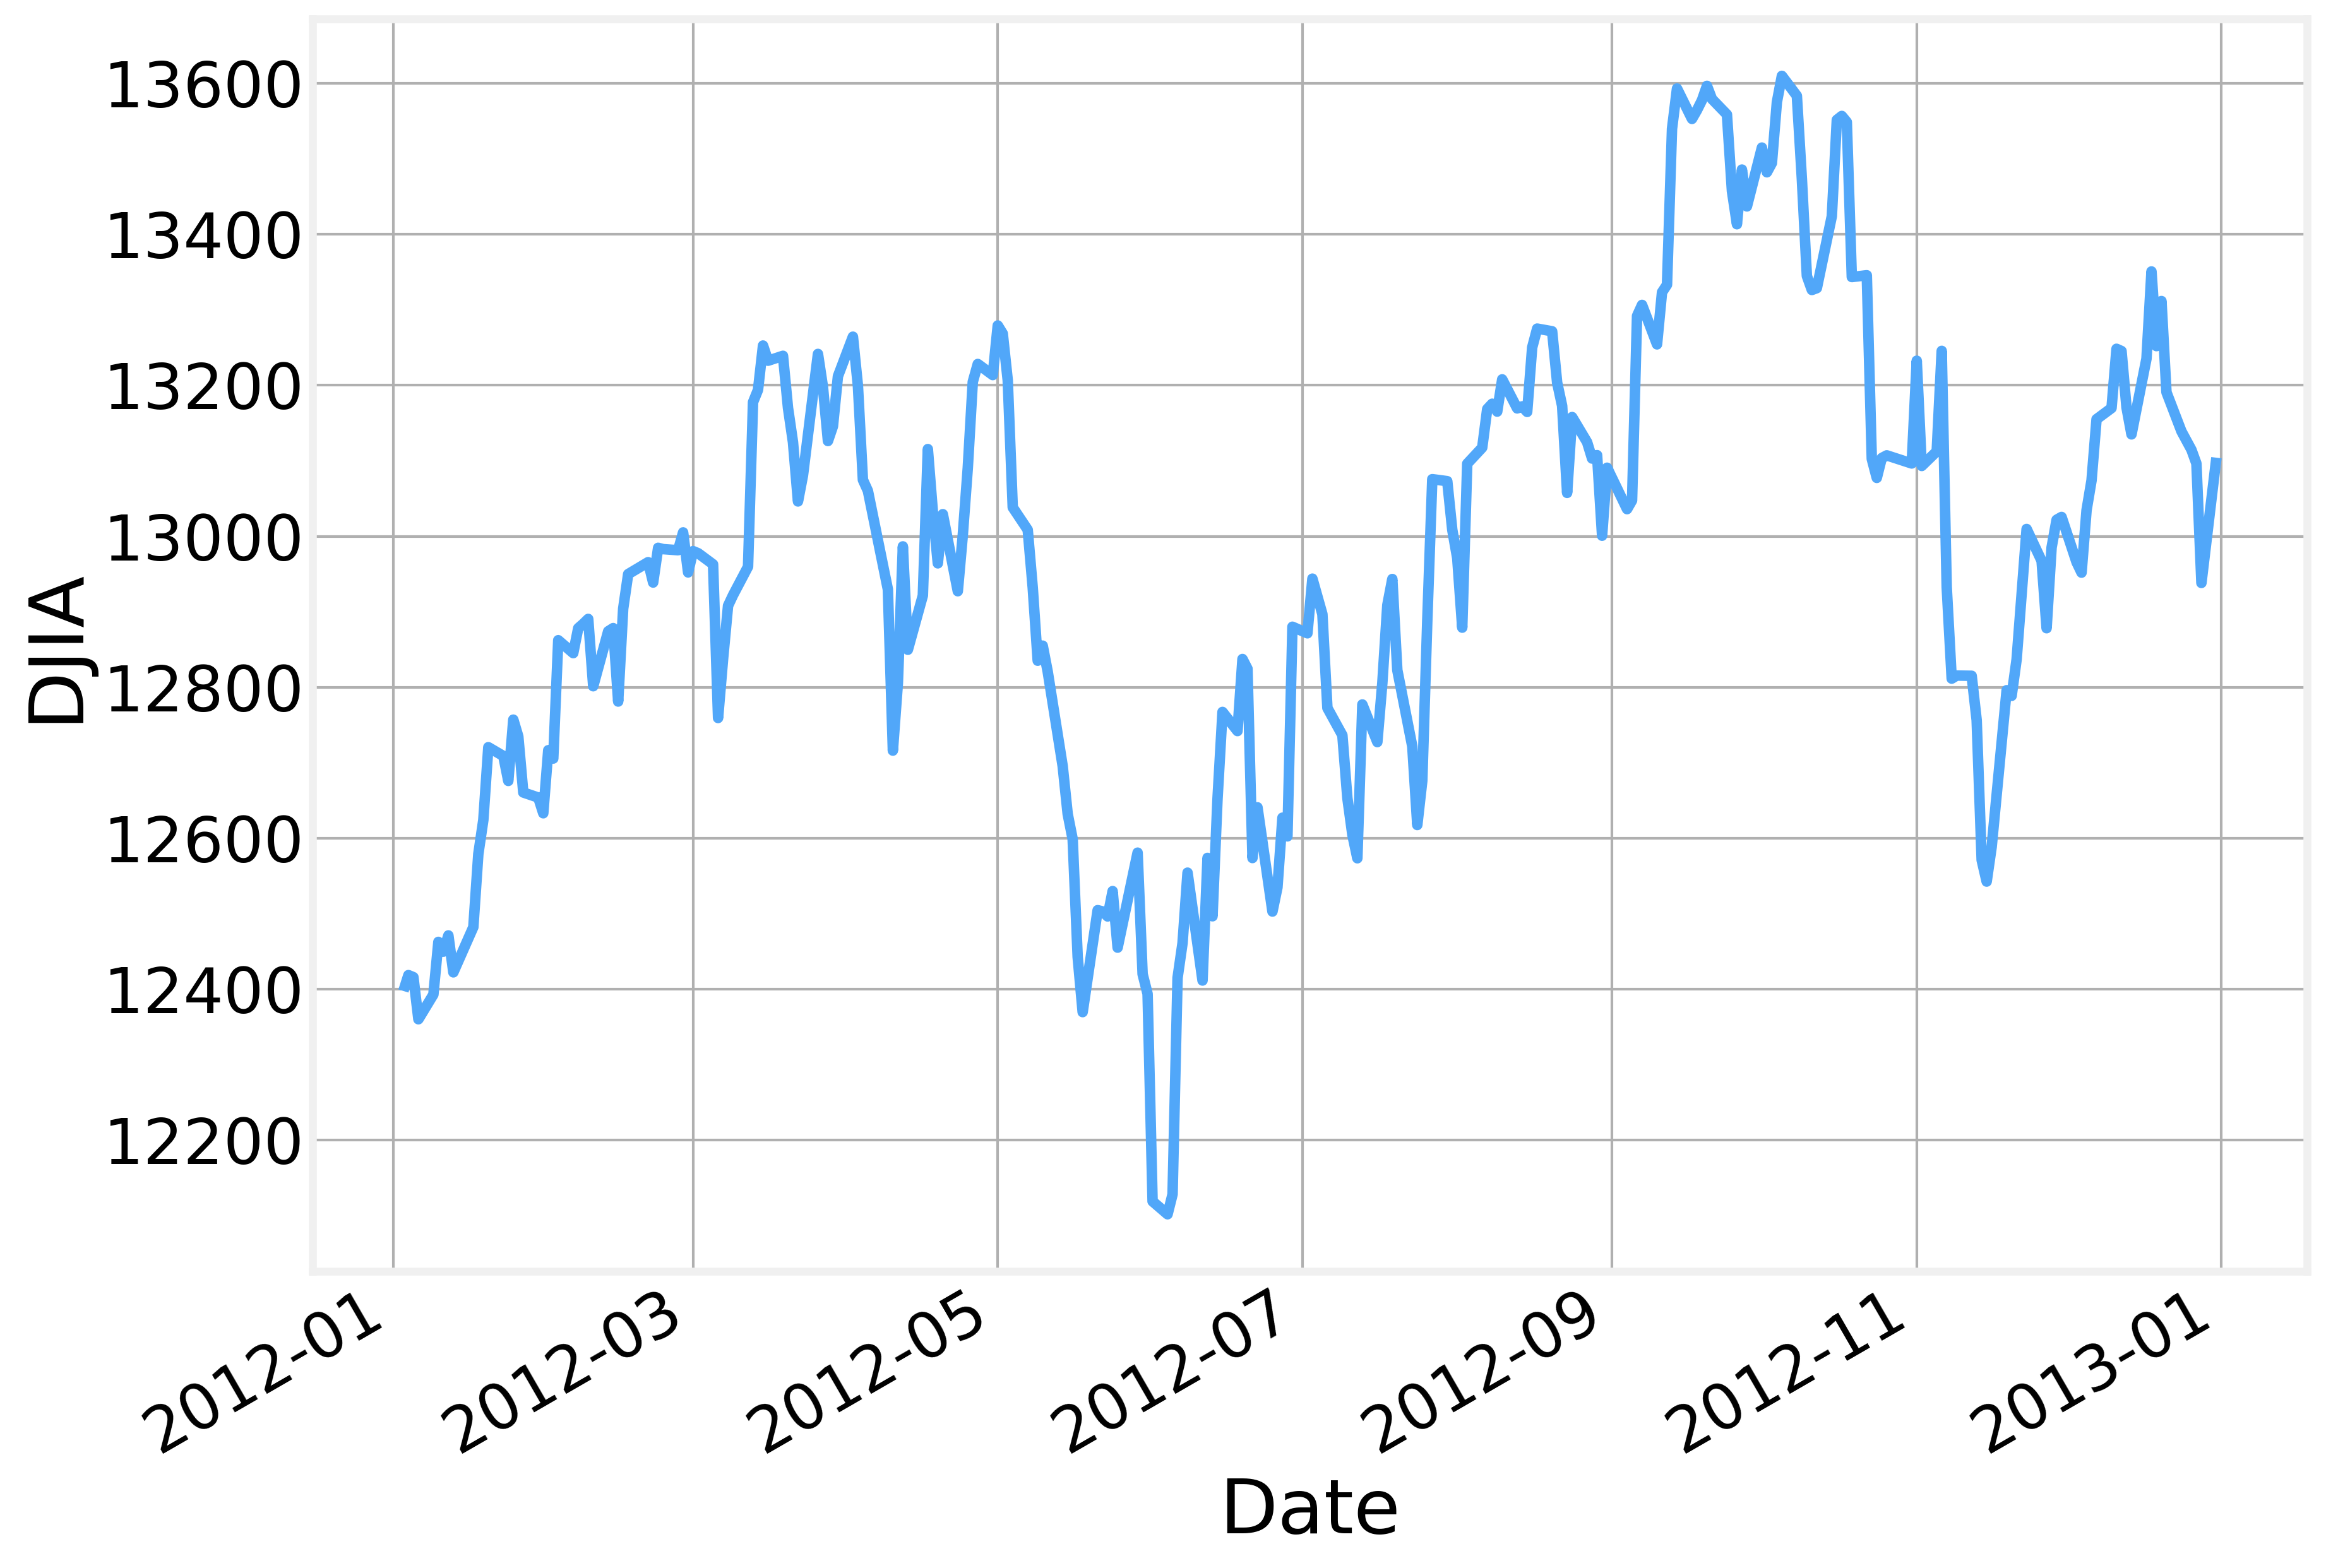

In [80]:
DJIA_2012 = DJIA['2012'].copy()

DJIA_2012.plot(legend=False)
ax = plt.gca()
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')

And look at a few different lagged values

In [12]:
DJIA_2012['forward 1W'] = DJIA_2012['DJIA'].shift(7)
DJIA_2012['backward 1W'] = DJIA_2012['DJIA'].shift(-7)

We can easily see how this has moved the values within each column. In the forward column we've added 7 __NaN__ values and copied all the original values starting at position 8 while in the backward column the first value we see is the value that in the real data only occured at index 8

In [15]:
DJIA_2012.iloc[:8]

,DJIA,forward 1W,backward 1W
DATE,,,
2012-01-03,12397.38,NaN,12471.02
2012-01-04,12418.42,NaN,12422.06
2012-01-05,12415.70,NaN,12482.07
2012-01-06,12359.92,NaN,12578.95
2012-01-09,12392.69,NaN,12623.98
2012-01-10,12462.47,NaN,12720.48
2012-01-11,12449.45,NaN,12708.82
2012-01-12,12471.02,12397.38,12675.75


The opposite is true if we look at the tail end of the DataFrame

In [19]:
DJIA_2012.iloc[-8:]

,DJIA,forward 1W,backward 1W
DATE,,,
2012-12-19,13251.97,13169.88,13104.14
2012-12-20,13311.72,13248.44,NaN
2012-12-21,13190.84,13245.45,NaN
2012-12-24,13139.08,13170.72,NaN
2012-12-26,13114.59,13135.01,NaN
2012-12-27,13096.31,13235.39,NaN
2012-12-28,12938.11,13350.96,NaN
2012-12-31,13104.14,13251.97,NaN


Visually, the effect is clear:

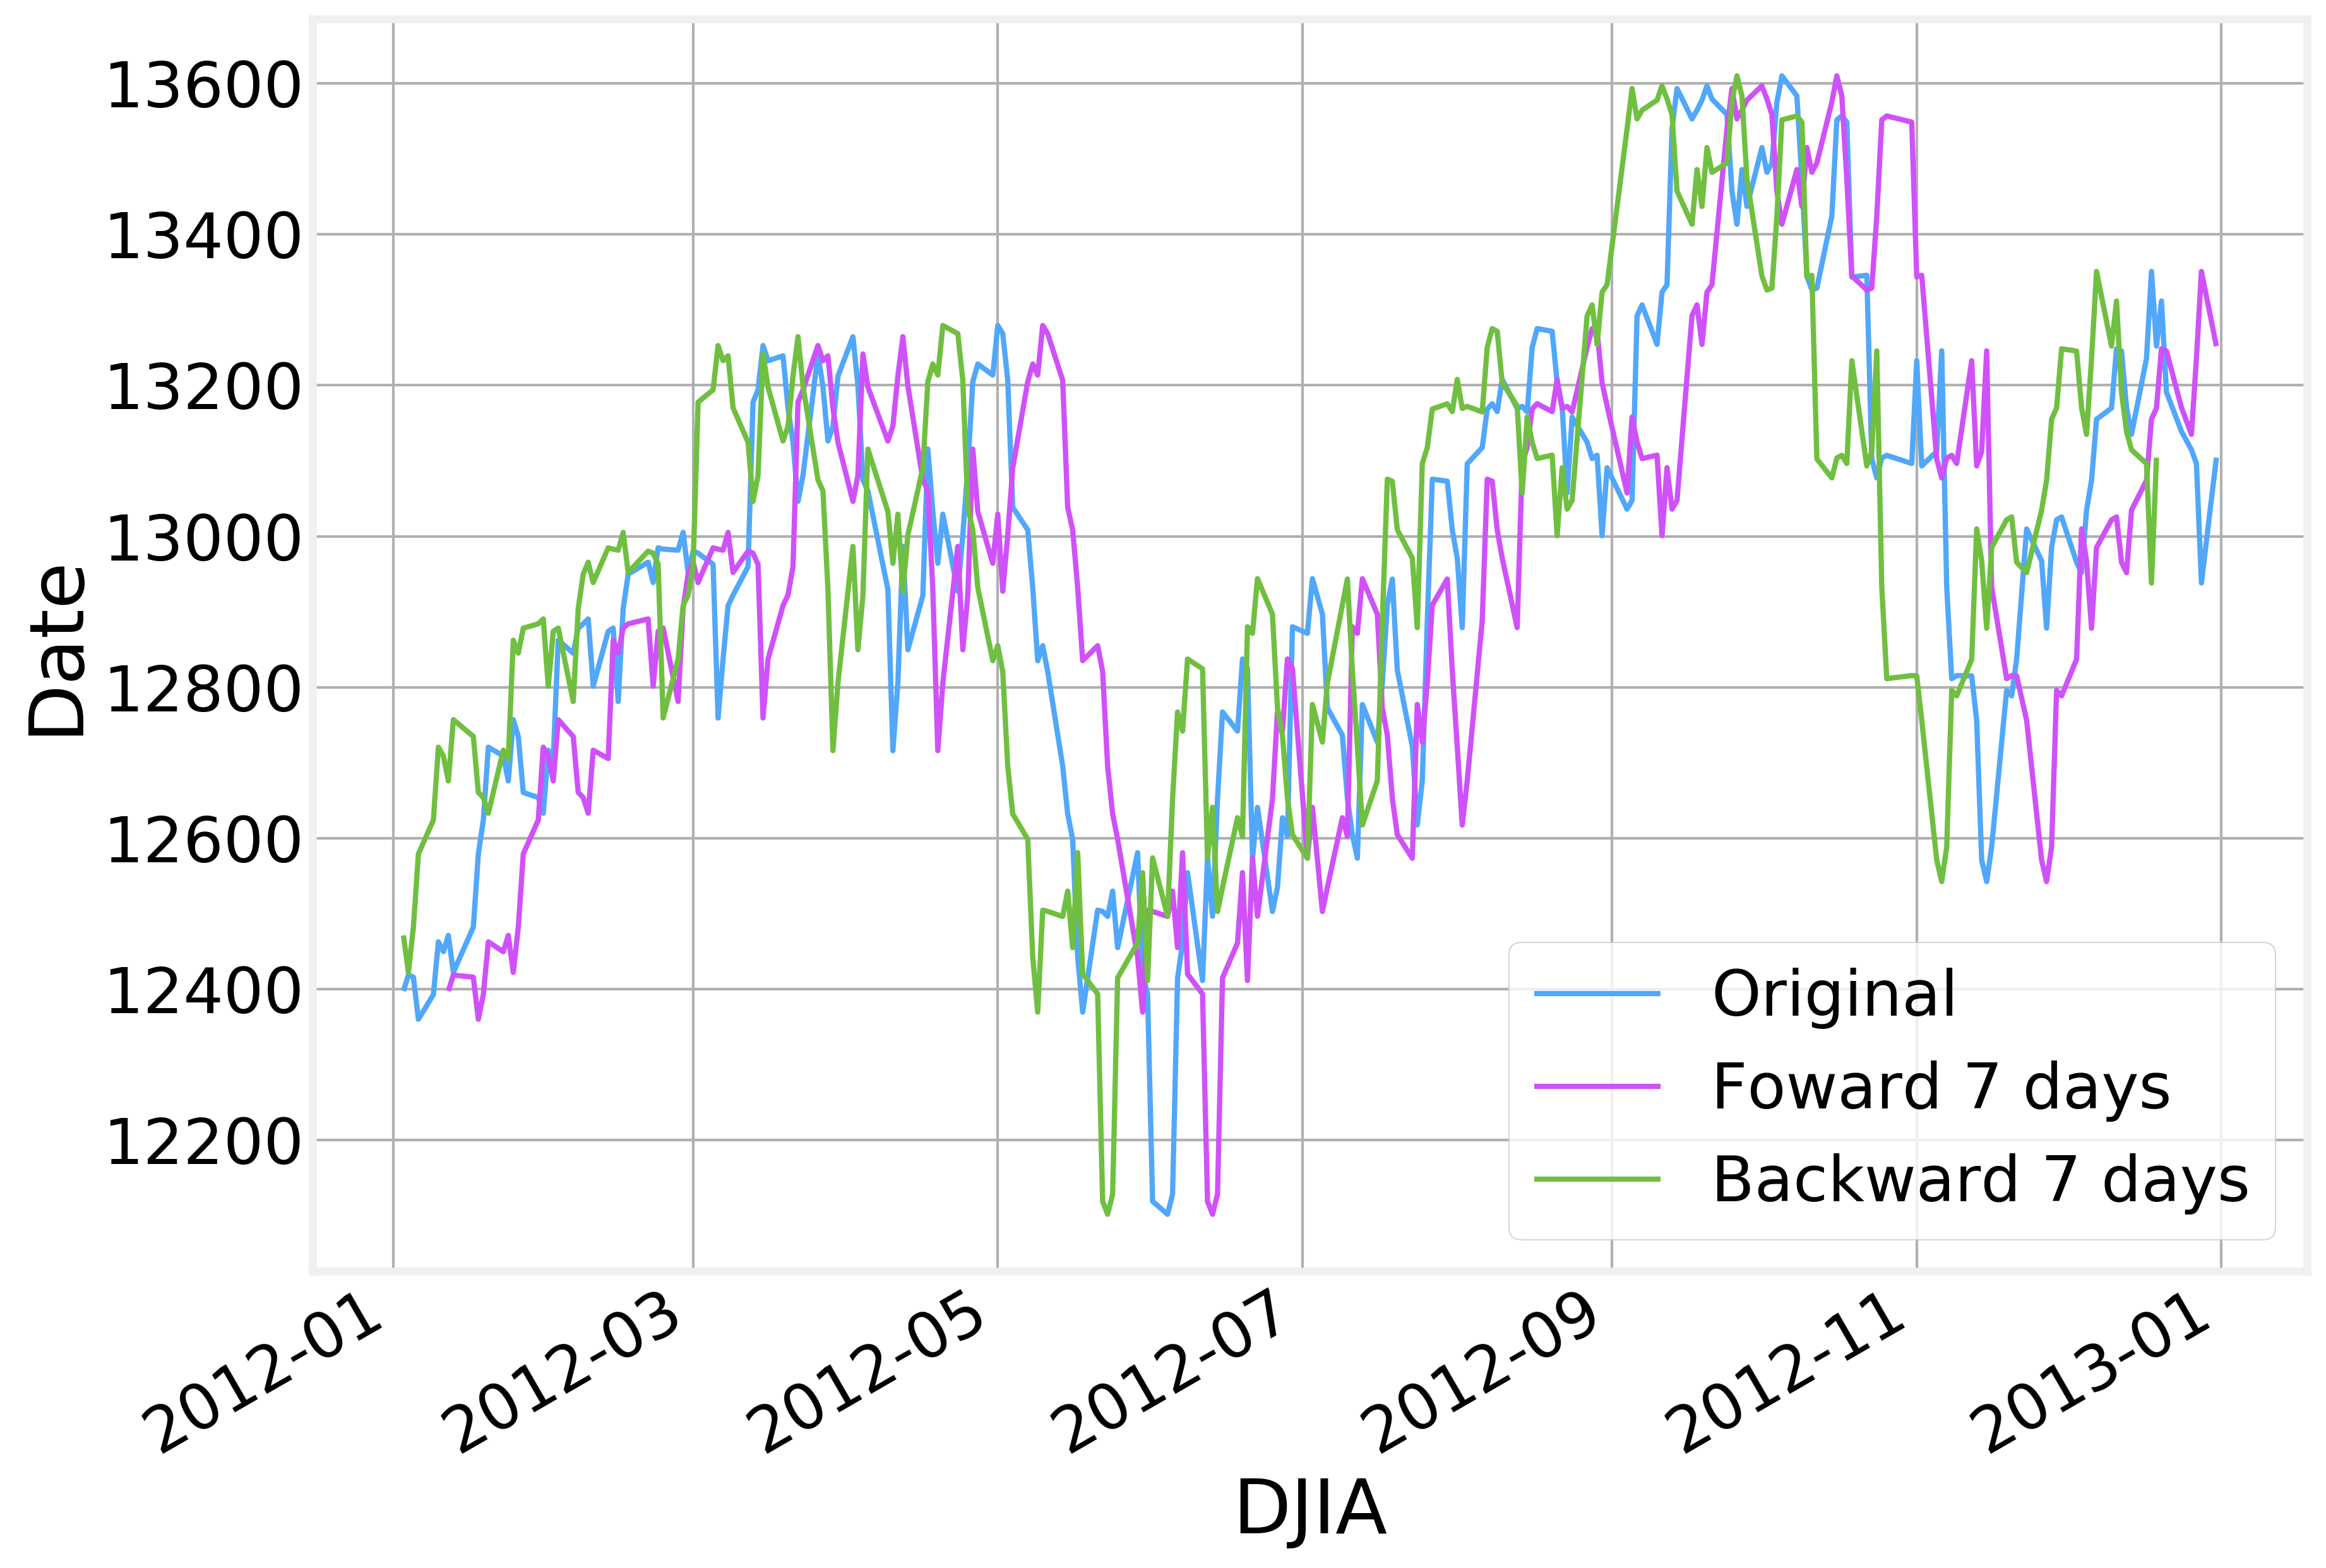

In [18]:
ax = DJIA_2012.plot(lw=2)
ax.set_xlabel('DJIA')
ax.set_ylabel('Date')
ax.legend(['Original', 'Foward 7 days', 'Backward 7 days'])

### Exercise

Plot the Sunpot dataset shifted forward and backwards 11 years

In [81]:
# %load solutions/sunspots_shifted.py

Why do the peaks line up?

## Differences

One way of removing the trend from a dataset is to differentiate it. Since we are dealing with discretized datasets this is the same as using finite differences.

Pandas provides the __diff()__ function to achieve this purpose. So we can calculate the day to day difference easily:

In [40]:
DJIA_2012['diff'] = DJIA_2012['DJIA'].diff(1)

__diff()__ follows the same conventions as __shift__ so positive values correspond to shifts towards the future. Here the "diff" value at 2012-01-04 is the difference between the values on Jan 4 and Jan 3 $$12418.42-12397.38=21.04$$
Naturally, this also implies that we add __NaN__ values to our timeseries

In [43]:
DJIA_2012

,DJIA,forward 1W,backward 1W,diff
DATE,,,,
2012-01-03,12397.38,NaN,12471.02,NaN
2012-01-04,12418.42,NaN,12422.06,21.04
2012-01-05,12415.70,NaN,12482.07,-2.72
2012-01-06,12359.92,NaN,12578.95,-55.78
2012-01-09,12392.69,NaN,12623.98,32.77
...,...,...,...,...
2012-12-24,13139.08,13170.72,NaN,-51.76
2012-12-26,13114.59,13135.01,NaN,-24.49
2012-12-27,13096.31,13235.39,NaN,-18.28


In [82]:
def differentiate(values, d=1, fill=False):
    x = values.diff(1).copy()
    
    # We replace the NaN value with the first value of the series
    # so that we can recover the original values with cumsum()
    if fill:
        x.iloc[0] = values.iloc[0]

    if d == 1:
        return x
    else:    
        return difference(x, d - 1)

In [83]:
values = DJIA_2012[['DJIA']]
differences = differentiate(values)

As we can see, the difference plot is significantly more stationary.

Text(0, 0.5, 'Differences')

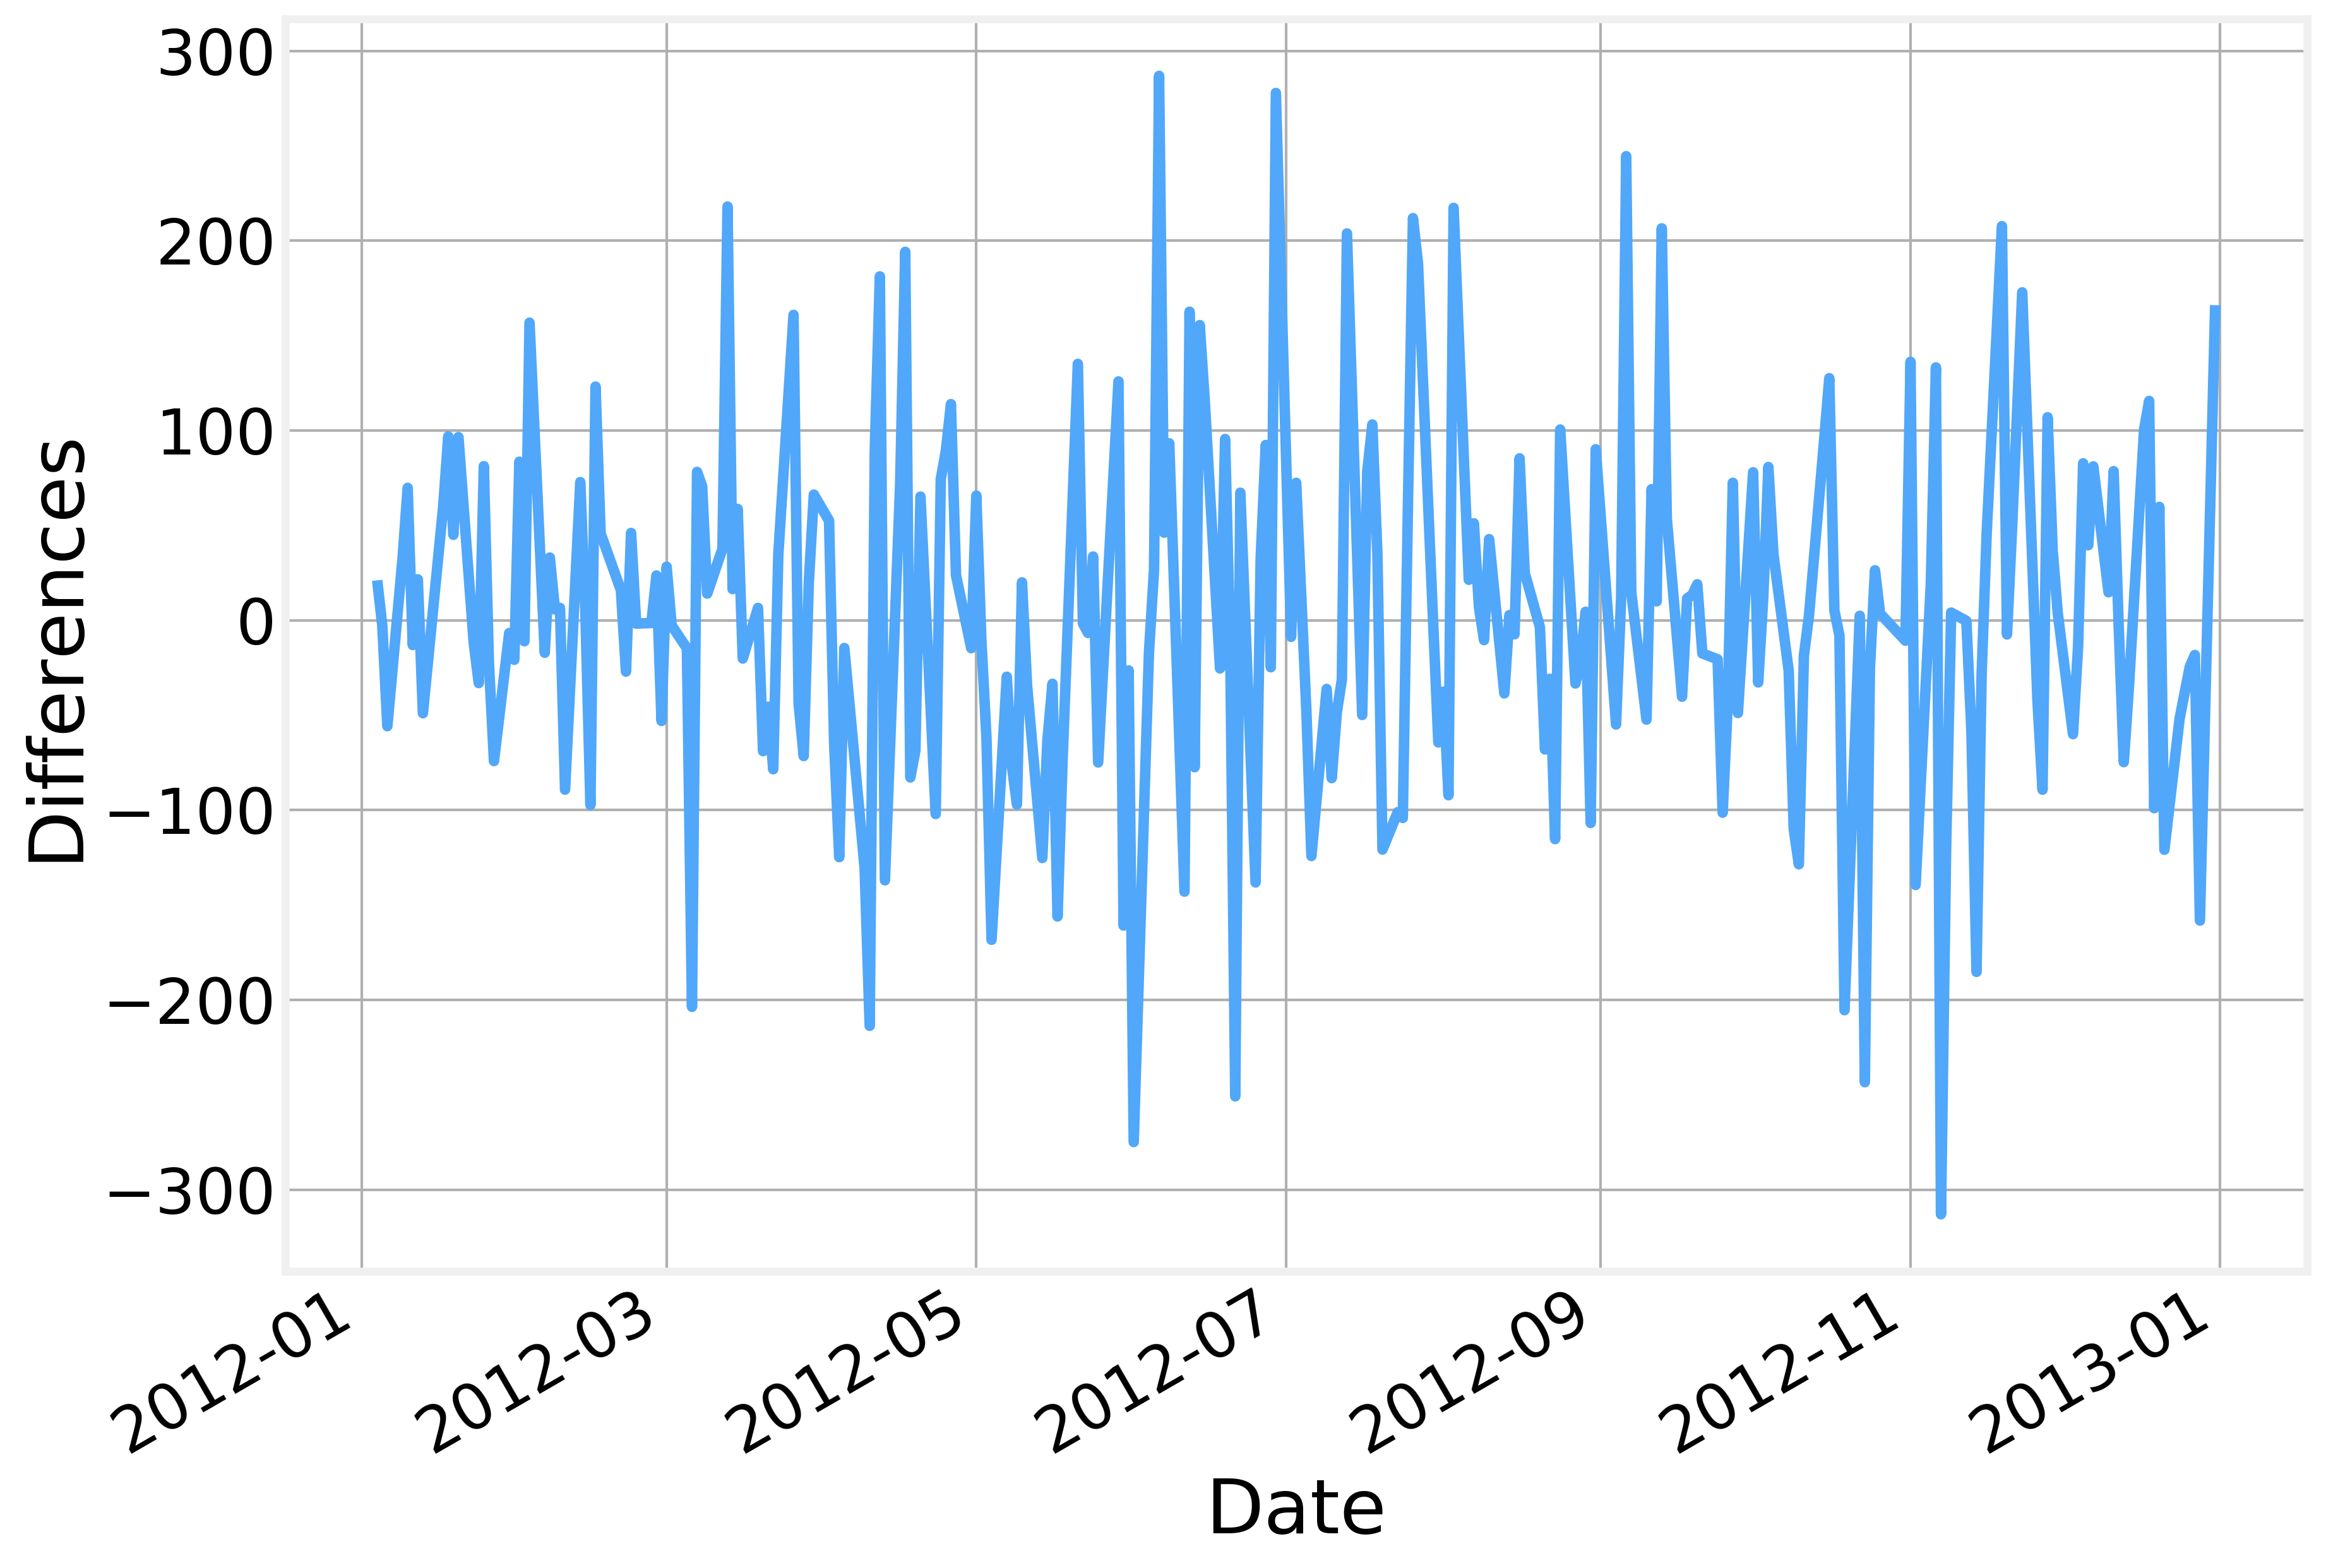

In [86]:
ax = differences.plot(legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('Differences')

The opposite operation is to integrate (sum) over the differences

In [90]:
def integrate(values, d=1):
    x = values.cumsum().copy()
    
    if d == 1:
        return x
    else:
        return integrate(x, d-1)

In [91]:
rebuilt = integrate(differences)

As we can see, the resulting values are very different from the original ones.

In [94]:
rebuilt

,DJIA
DATE,
2012-01-03,NaN
2012-01-04,21.04
2012-01-05,18.32
2012-01-06,-37.46
2012-01-09,-4.69
...,...
2012-12-24,741.70
2012-12-26,717.21
2012-12-27,698.93


The way to fix this is to replace the first NaN value with the corresponding value in the original time series. In the differentiate function we defined above we just have to add the __fill=True__ option

In [95]:
diffs = differentiate(values, fill=True)

And now we are able to recoved all the original values

In [97]:
(integrate(diffs)-values).sum()

DJIA    0.0
dtype: float64

## Missing Data

Unfortunately, data is not always clean or complete, forcing us to deal with missing data points. Here we illustrate several approaches to inputating missing values. We start by generating a dataset with missing values

In [21]:
x = np.linspace(-np.pi, np.pi, 100)
y = np.cos(x)
y_missing = y.copy()
y_missing[40:55] = np.nan

This is simply a cosine function with a few missing values at the peak.

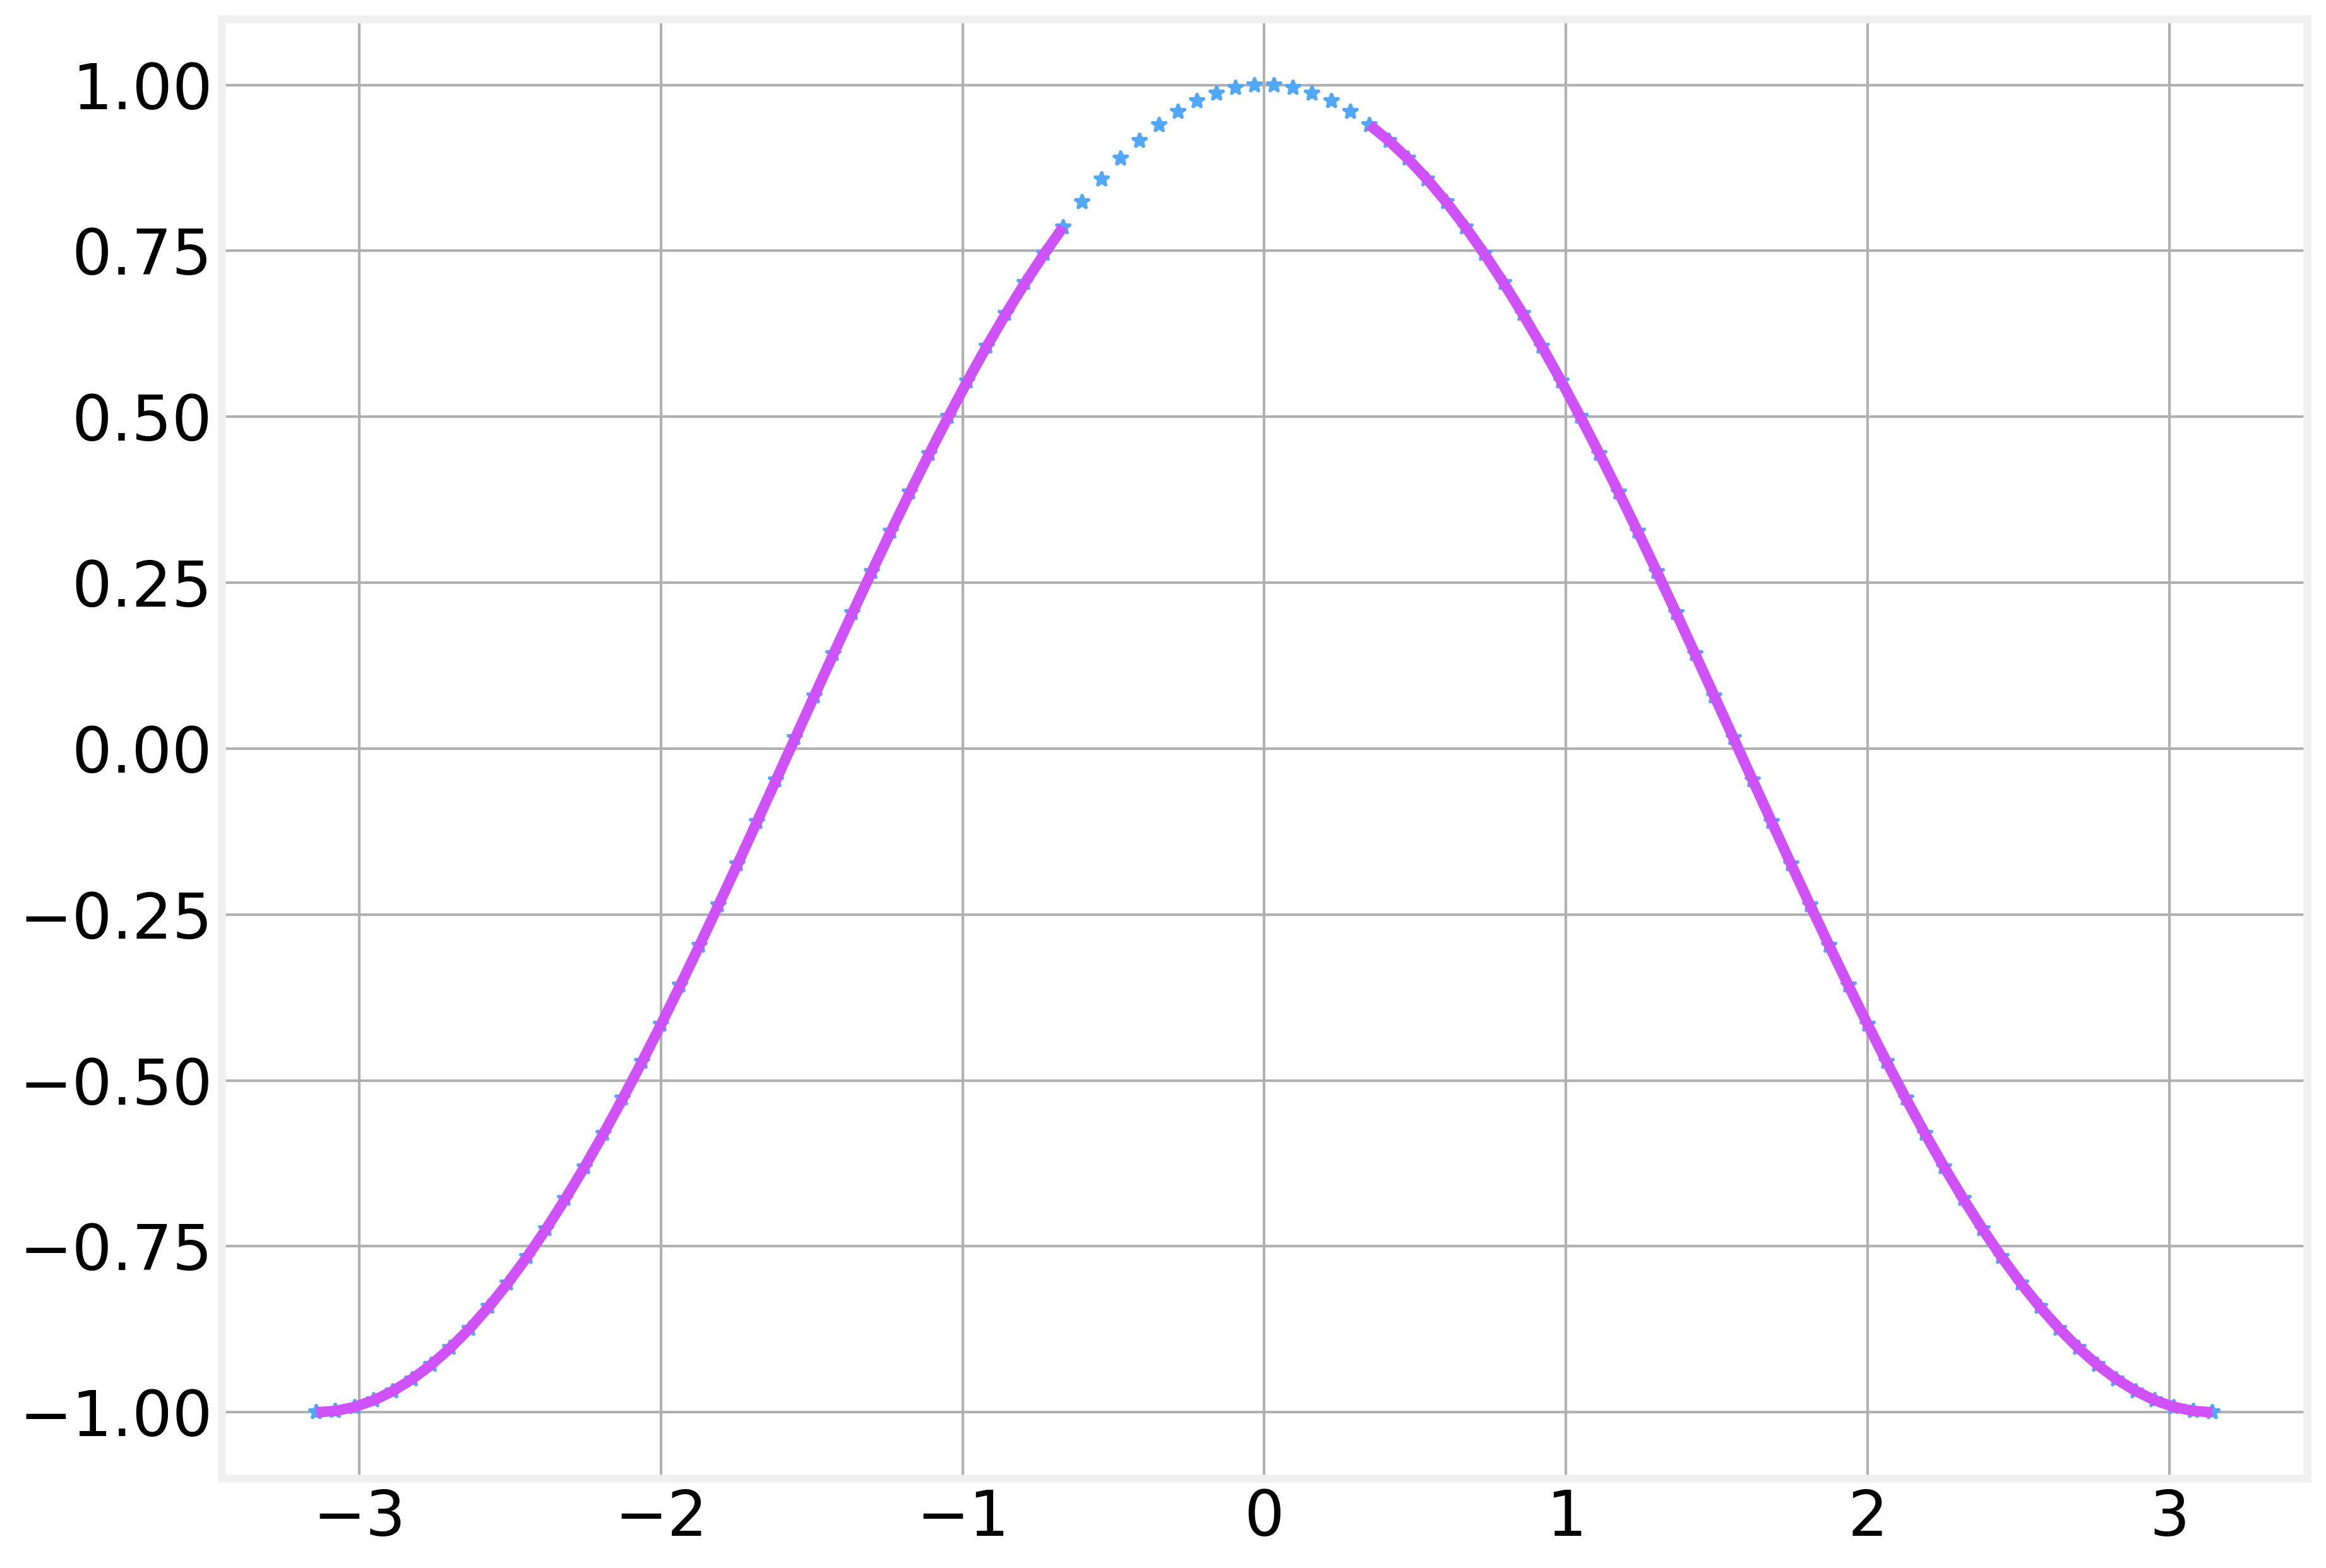

In [22]:
plt.plot(x, y, '*')
plt.plot(x, y_missing)

Perhaps the most common strategy is to simply keep the last known 'good' value and use it to fill in the missing data points. This approach is unable to deal with missing values at the beginning of the dataset.

In [23]:
def bfill(y):
    y0 = y.copy()
    N = len(y0)
    
    current = None
    for i in range(1, N):
        if np.isnan(y0[i]):
            y0[i] = current
        else:
            current = y0[i]
    
    return y0

Naturally, the opposite approach is also common where we use the next good value. In this way we can easly handling missing the initial values but can do nothing about any values lost at the end of the time series

In [24]:
def ffill(y):
    y0 = y.copy()
    N = len(y0)
    
    current = None
    for i in range(N-1, 0, -1):
        if np.isnan(y0[i]):
            y0[i] = current
        else:
            current = y0[i]
    
    return y0

Back-fill and Forward-fill are simple but powerful approachs to deal with missing data. However, we often want to be more careful about wchich value we inpute. One common approach is to interpolate between the previous and the next value and connecting them with a straight line. 

In [25]:
def interpolate(y):
    y0 = y.copy()
    N = len(y0)
    
    pos = 0
    while pos < N:
        if np.isnan(y0[pos]):
            count = 0
            
            while np.isnan(y0[pos+count]):
                count += 1
            
            current = y0[pos-1]
            future = y0[pos+count]
            slope = (future-current)/count
            
            y0[pos:pos+count] = current + np.arange(1, count+1)*slope
            
            pos += count
        else:
            pos += 1
            
    return y0

Data inputation (the calculation of the expected missing values) is a large subfield of statistics with a wide range of techniques and approaches. See https://en.wikipedia.org/wiki/Imputation_(statistics) for some pointer to more sophisticated methodologies

In [26]:
y_bfill = bfill(y_missing)
y_ffill = ffill(y_missing)
y_inter = interpolate(y_missing)

And a quick plot to visualize the differences

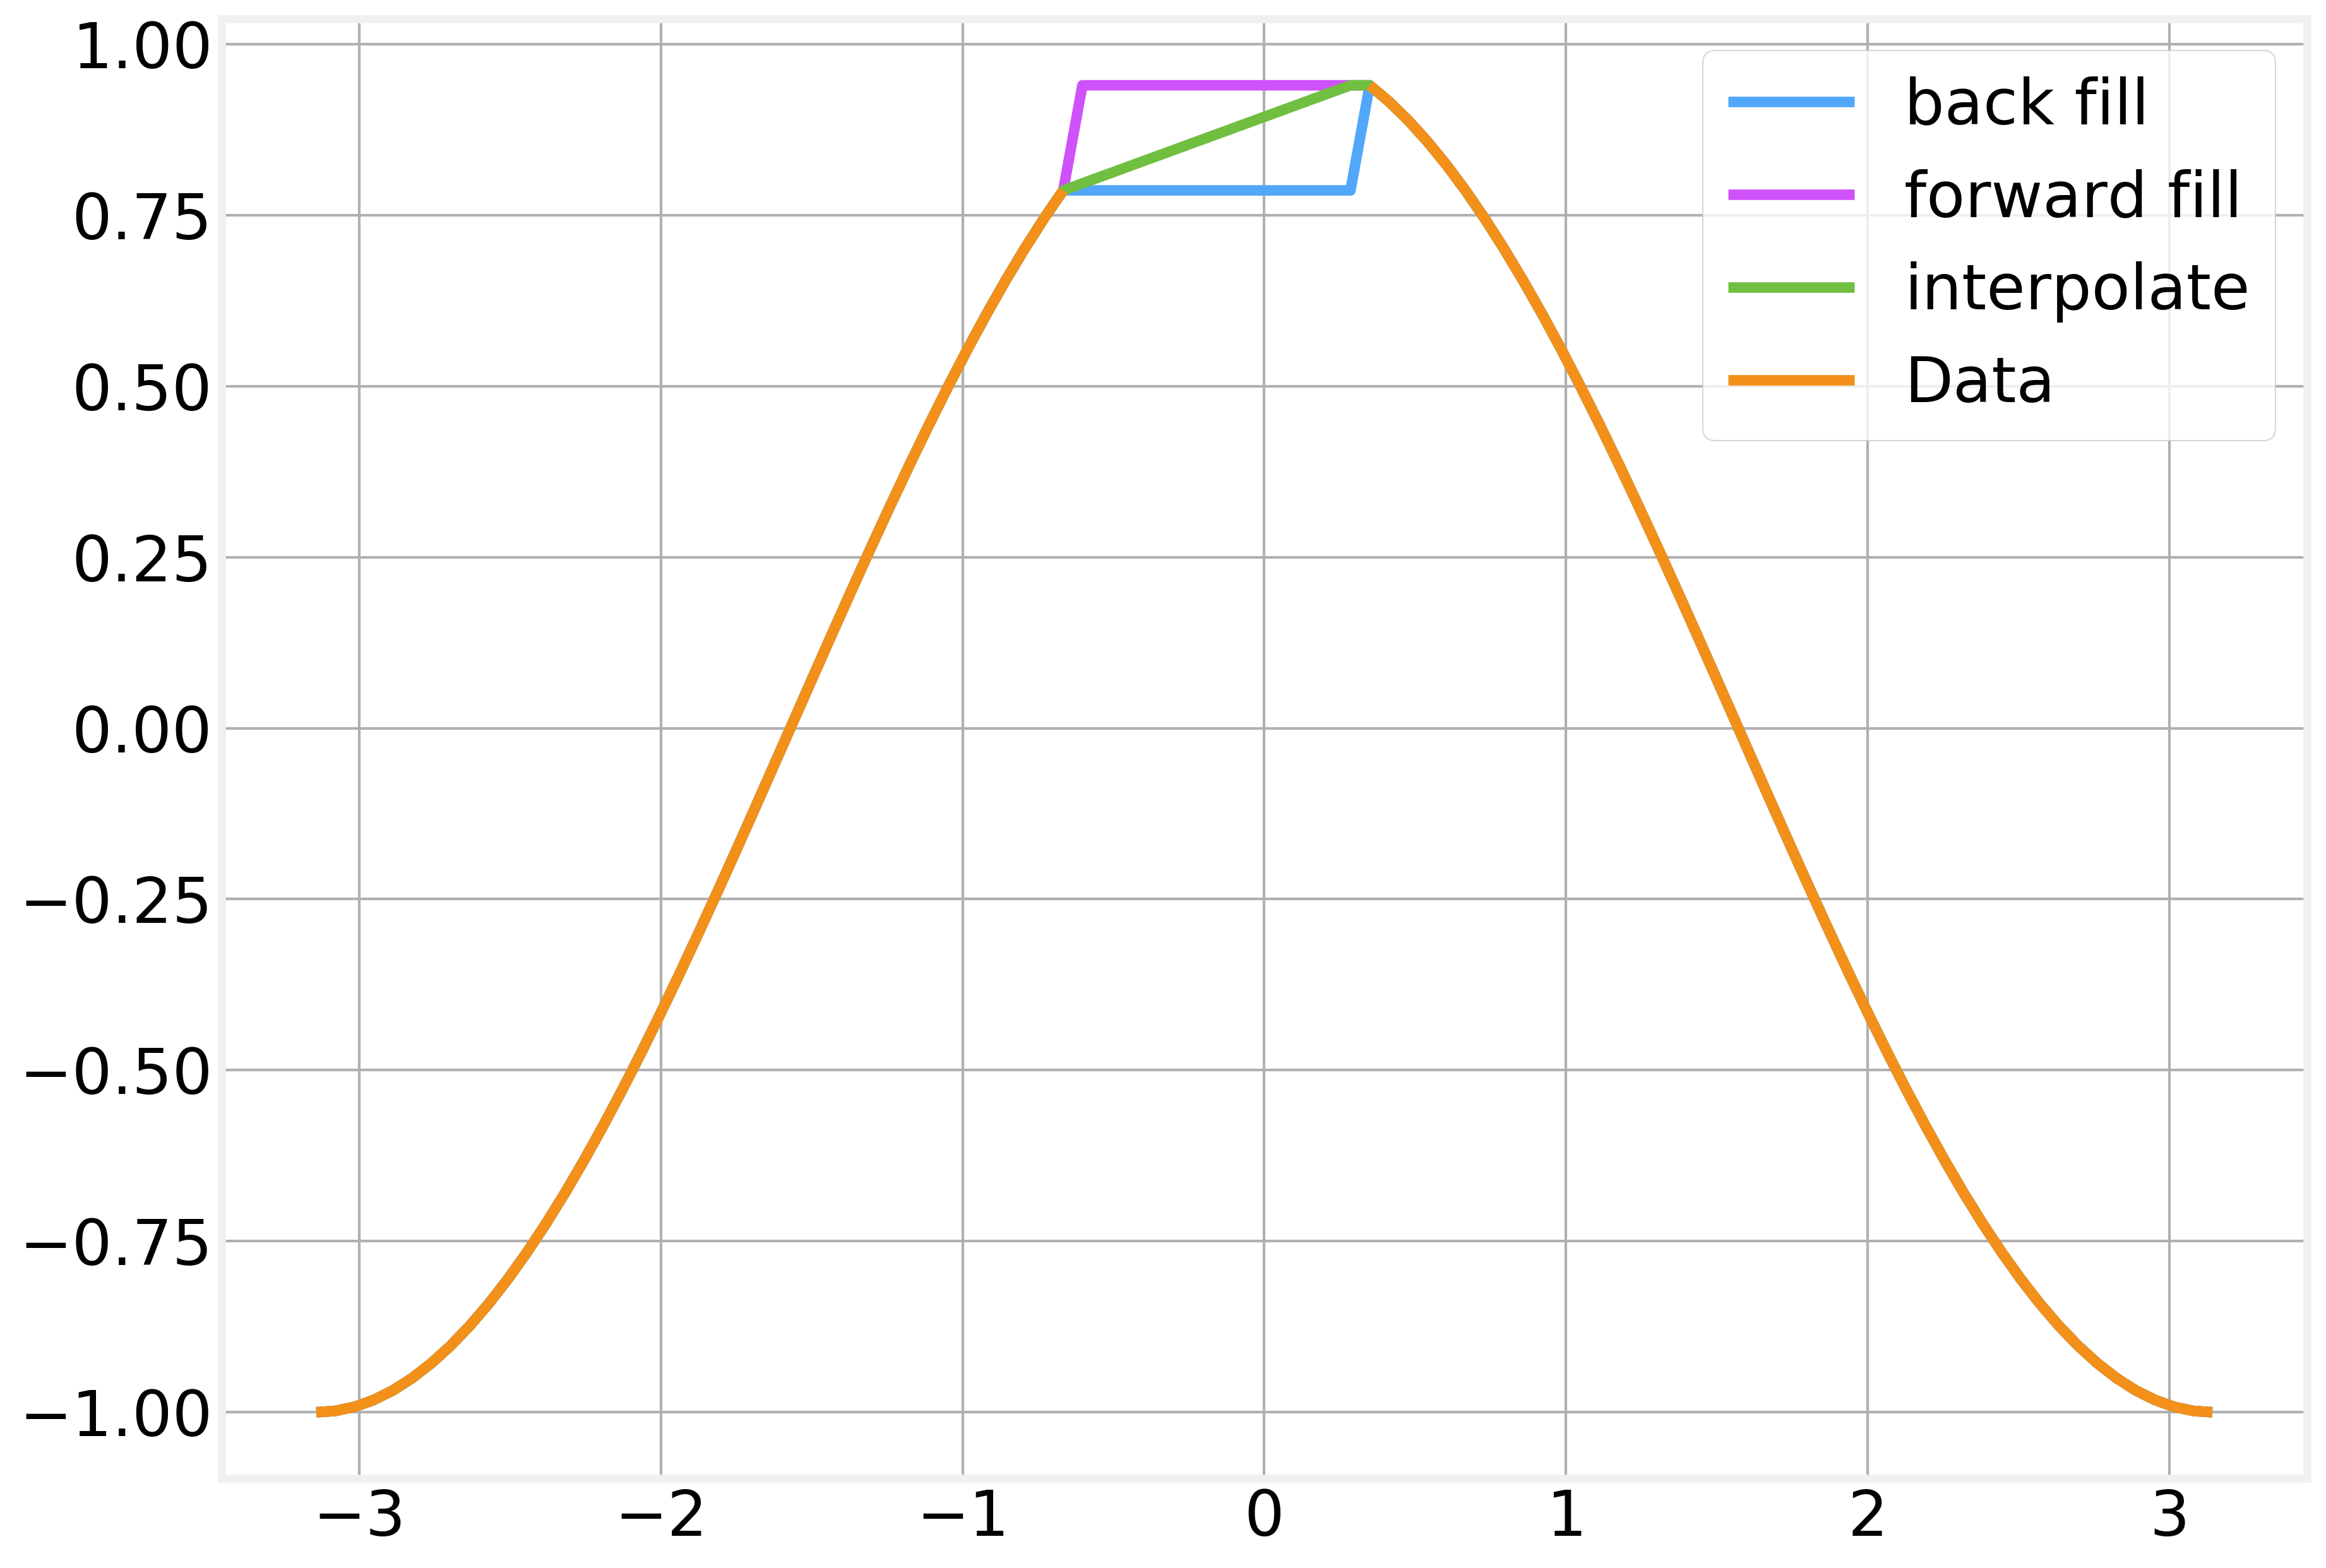

In [27]:
plt.plot(x, y_bfill, label='back fill')
plt.plot(x, y_ffill, label='forward fill')
plt.plot(x, y_inter, label='interpolate')
plt.plot(x, y_missing, label='Data')
plt.legend()

## Resampling

In many cases we also need to change the frequency at which we are operating. For example, our DJIA dataset has end of day values, but we might be interested in weekly or monthly data points. Resampling is a series of techniques designed to deal with this situation and is similar in spirit to the windowing techniques we saw above. The main difference is that instead of simply moving the window at a fixed step we have each window correspond to our period of interest.

In [28]:
mapping = DJIA['DATE'].dt.year
values = DJIA['DJIA'].values

In the simplest case we simply calculate what the correct window is for each data point and aggregate accordingly

In [29]:
def groupBy(values, mapping, func = None):
    agg = {}
    pos = {}
    
    for i in range(values.shape[0]):
        key = mapping.iloc[i]
        
        if key not in agg:
            agg[key] = []
        
        pos[key] = i
        
        if not np.isnan(values[i]):
            agg[key].append(values[i])
        
    order = sorted(agg.keys())
    
    if func is not None:
        for key in agg:
            agg[key] = func(np.array(agg[key]).astype('float'))
            
    return agg, pos

Naturally this groupBy function is useful not only for resampling but also for wide range of statistical analysis. In addition to a mapping, we must also specify what aggregation function we want to use. Are we interested in the average value? the maximum? standard deviation?

In [30]:
agg, pos = groupBy(values, mapping, np.mean)

Here we simply calculted the mean value for each year

In [31]:
agg

{2009: 10232.334385964914,
 2010: 10668.589087301589,
 2011: 11957.570238095239,
 2012: 12965.28744,
 2013: 15009.523492063492,
 2014: 16777.690912698414,
 2015: 17587.029166666664,
 2016: 17927.107341269842,
 2017: 21750.20374501992,
 2018: 25046.85734939759,
 2019: 26000.832040816327}

As our groupBy function also returns the index positions of the last time each bin was seen we can easily compare the original data with the resampled one.

In [32]:
aggregated = []

for key in pos:
    aggregated.append([pos[key], agg[key]])

aggregated = np.array(aggregated)

In [33]:
aggregated

array([[   56.        , 10232.33438596],
       [  308.        , 10668.5890873 ],
       [  560.        , 11957.5702381 ],
       [  810.        , 12965.28744   ],
       [ 1062.        , 15009.52349206],
       [ 1314.        , 16777.6909127 ],
       [ 1566.        , 17587.02916667],
       [ 1818.        , 17927.10734127],
       [ 2069.        , 21750.20374502],
       [ 2318.        , 25046.8573494 ],
       [ 2514.        , 26000.83204082]])

Text(0.5, 0, 'Date')

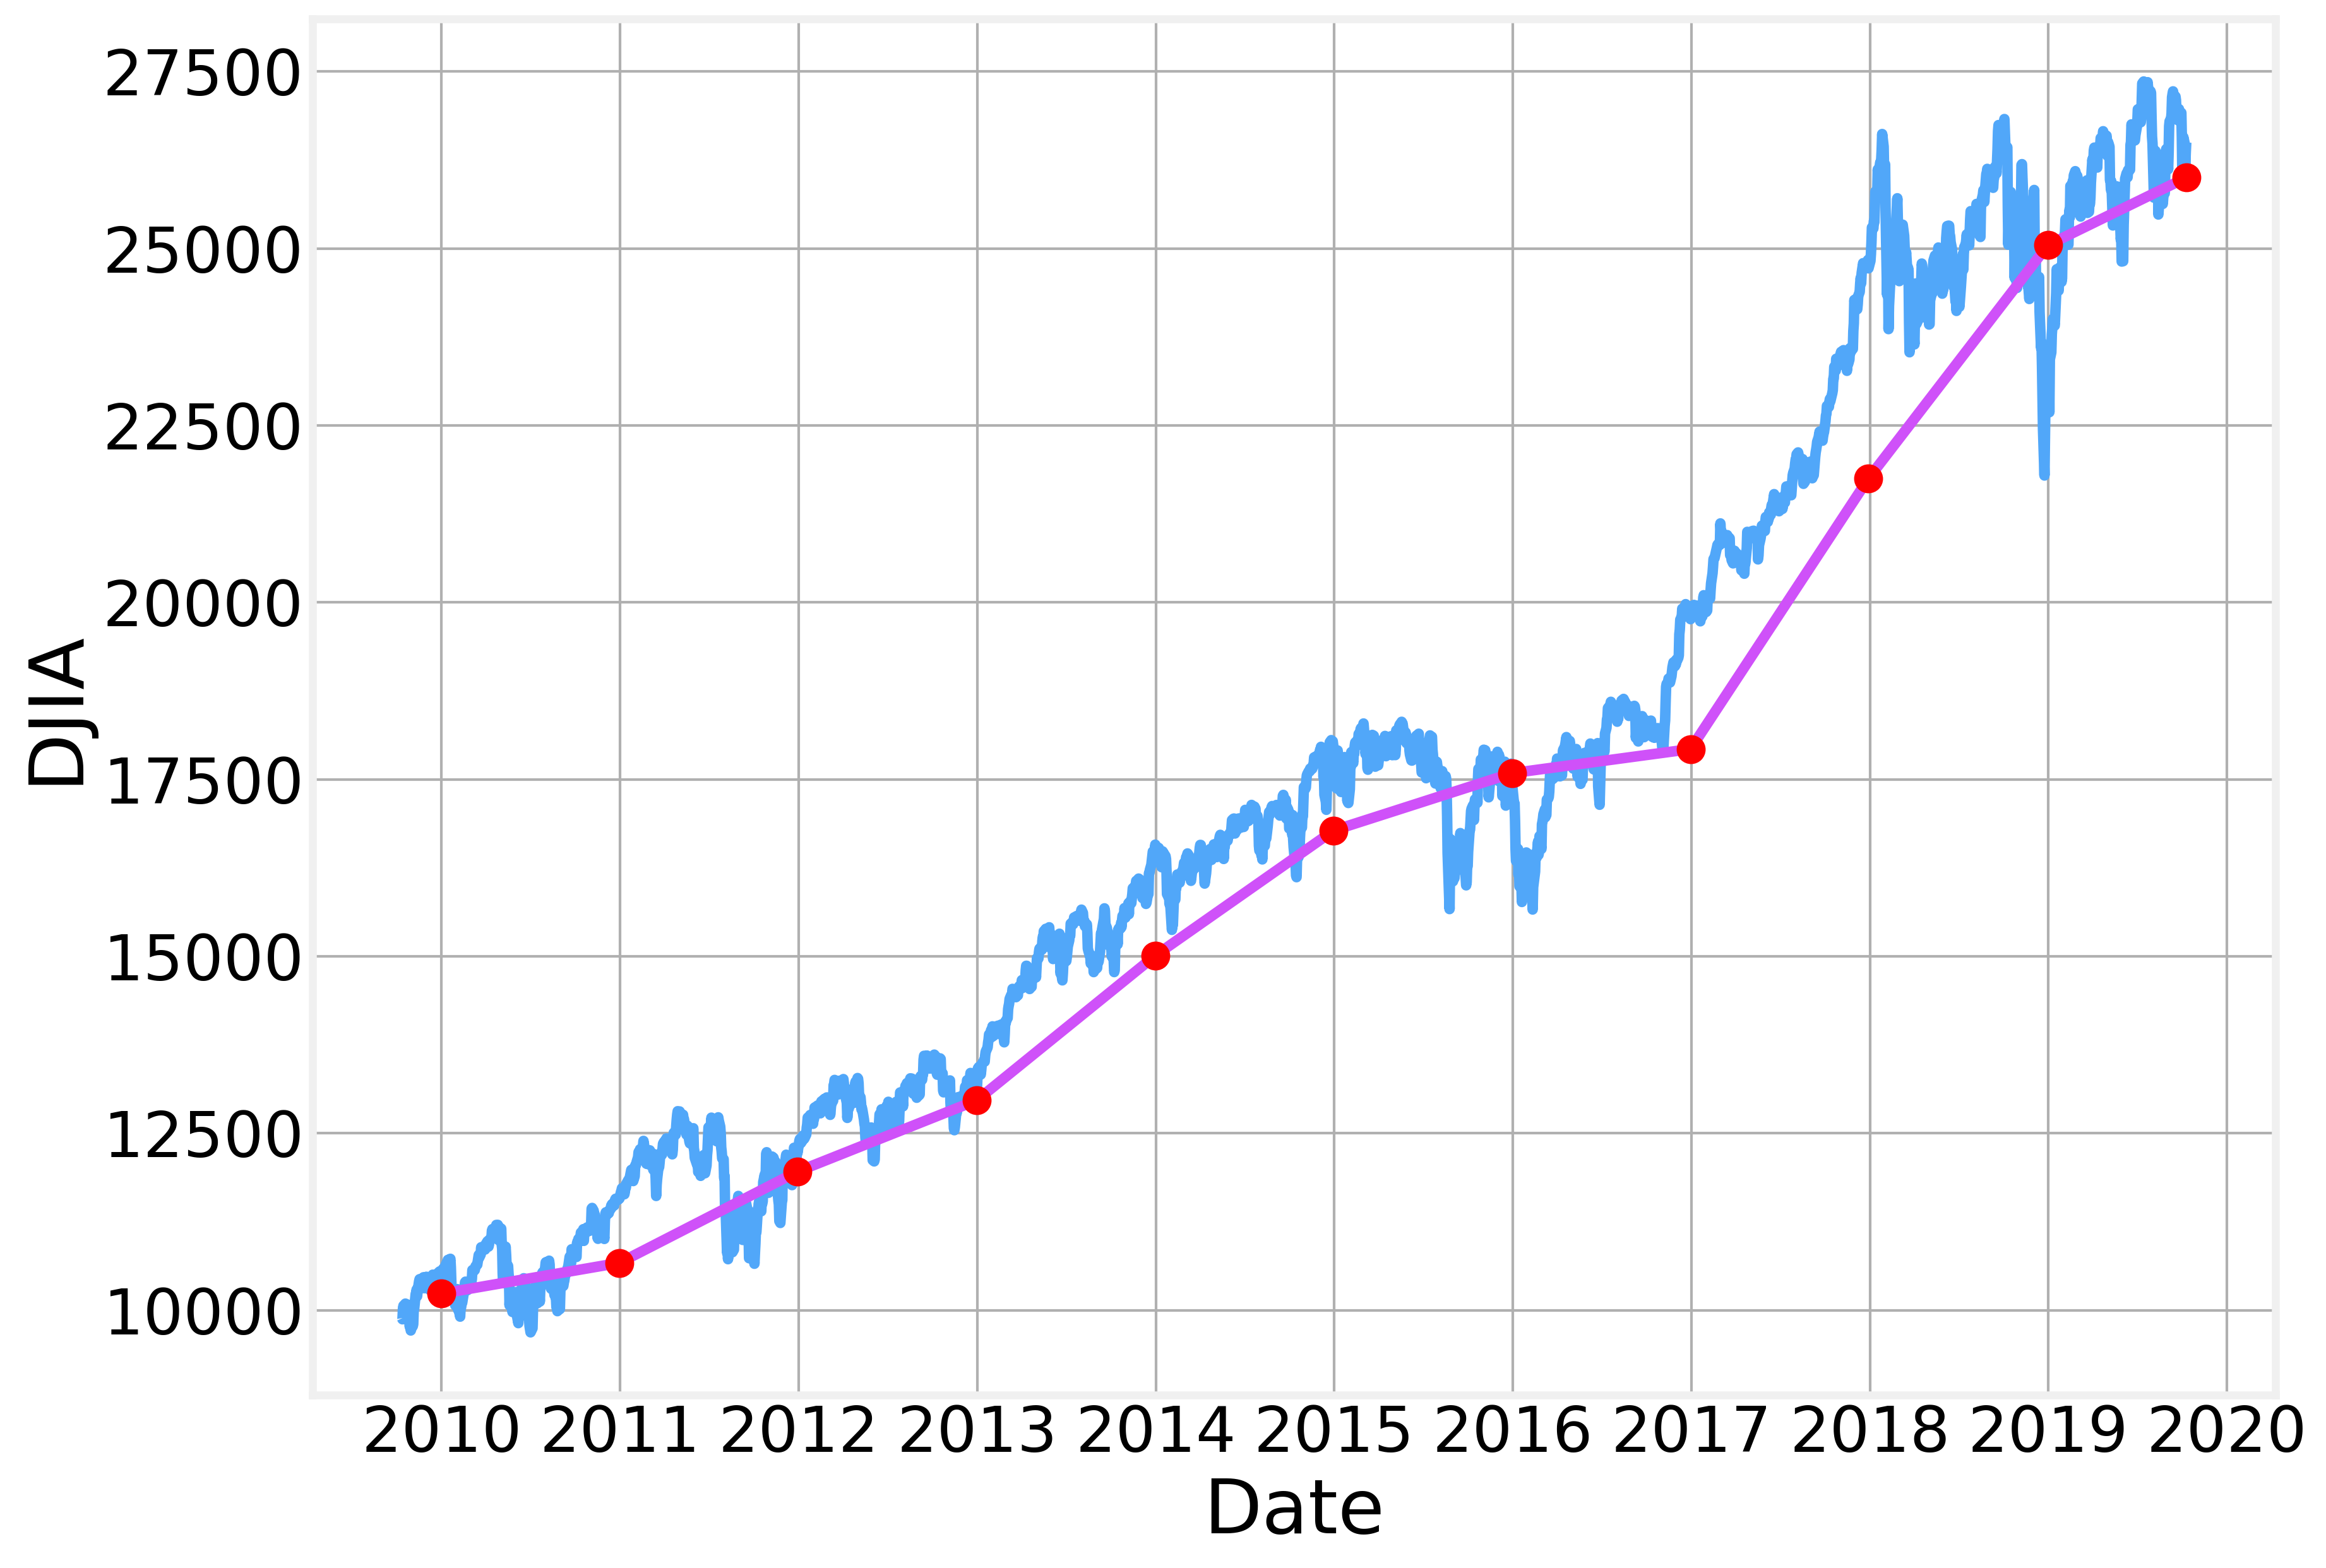

In [34]:
plt.plot(DJIA['DATE'], DJIA['DJIA'])
ax = plt.gca()
ax.plot(DJIA.set_index('DATE').index[aggregated.T[0].astype('int')], aggregated.T[1])
ax.plot(DJIA.set_index('DATE').index[aggregated.T[0].astype('int')], aggregated.T[1], 'ro', markersize=10,)
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')

## Jackknife estimators

Finally, in many cases we want to estimate statistical quantities of time series. An obvious example might be to estimage the running average of a detrended series to verify if it is indeed sufficiently close to zero to be considered stationary. 

The JackKnife estimator allows us to obtain not only the expected value in question, but also a measure of it's variance. This is achieved by using a leave-one out approach to compute N estimates of our metric. From this population of estimage, we can then obtain the averages as the best possible estimate and the standard deviation as a measure of the error bars involved

In [35]:
def jackknife(x, func, variance = False):
    N = len(x)
    pos = np.arange(N)
    values = [func(x[pos != i]) for i in pos]
    jack = np.sum(values)/N
    
    if variance:
        values = [np.power(func(x[pos != i]) - jack, 2.0) for i in pos]
        var = (N-1)/N * np.sum(values)
        return jack, var
    else:
        return jack

In [36]:
x = np.random.normal(0, 2, 100)
print(x.std())
jackknife(x, np.std, True)

1.911665257745568


(1.9115265236962904, 0.01559650246315687)

With jackknife we obtain not only an estimate of the value but also a measure of the error

## Bootstrapping

Another common technique to estimate statistical properties is known as bootstrapping and is closely related to the Jackknife. In this approach we simply sample (with replacement) from the original population to get a measure of how much variability can be expected

In [37]:
def bootstrapping(x, n_samples, func=np.mean):
    y = x.copy()
    N = len(y)
    population = []
    
    for i in range(n_samples):
        population.append(func(np.random.choice(y, N, replace=True)))
        
    return np.array(population)

We can easily generate a histogram over all the the bootstrapped samples

In [38]:
def histogram(values, n_bins=100):
    xmax = values.max()
    xmin = values.min()
    delta  = (xmax-xmin)/n_bins
    
    counts = np.zeros(n_bins+1, dtype='int')
    
    for value in values:
        val_bin = np.around((value-xmin)/delta).astype('int')
        counts[val_bin] += 1.0
    
    bins = xmin+delta*np.arange(n_bins+1)
    
    return bins, counts/values.shape[0]

In [39]:
x = np.random.normal(0, 2, size=100)

In [40]:
boot = bootstrapping(x, 1000)

In [41]:
x.mean()

0.08921981534302882

In [42]:
x.std()

2.4363004017687855

In [43]:
bins, counts = histogram(boot)

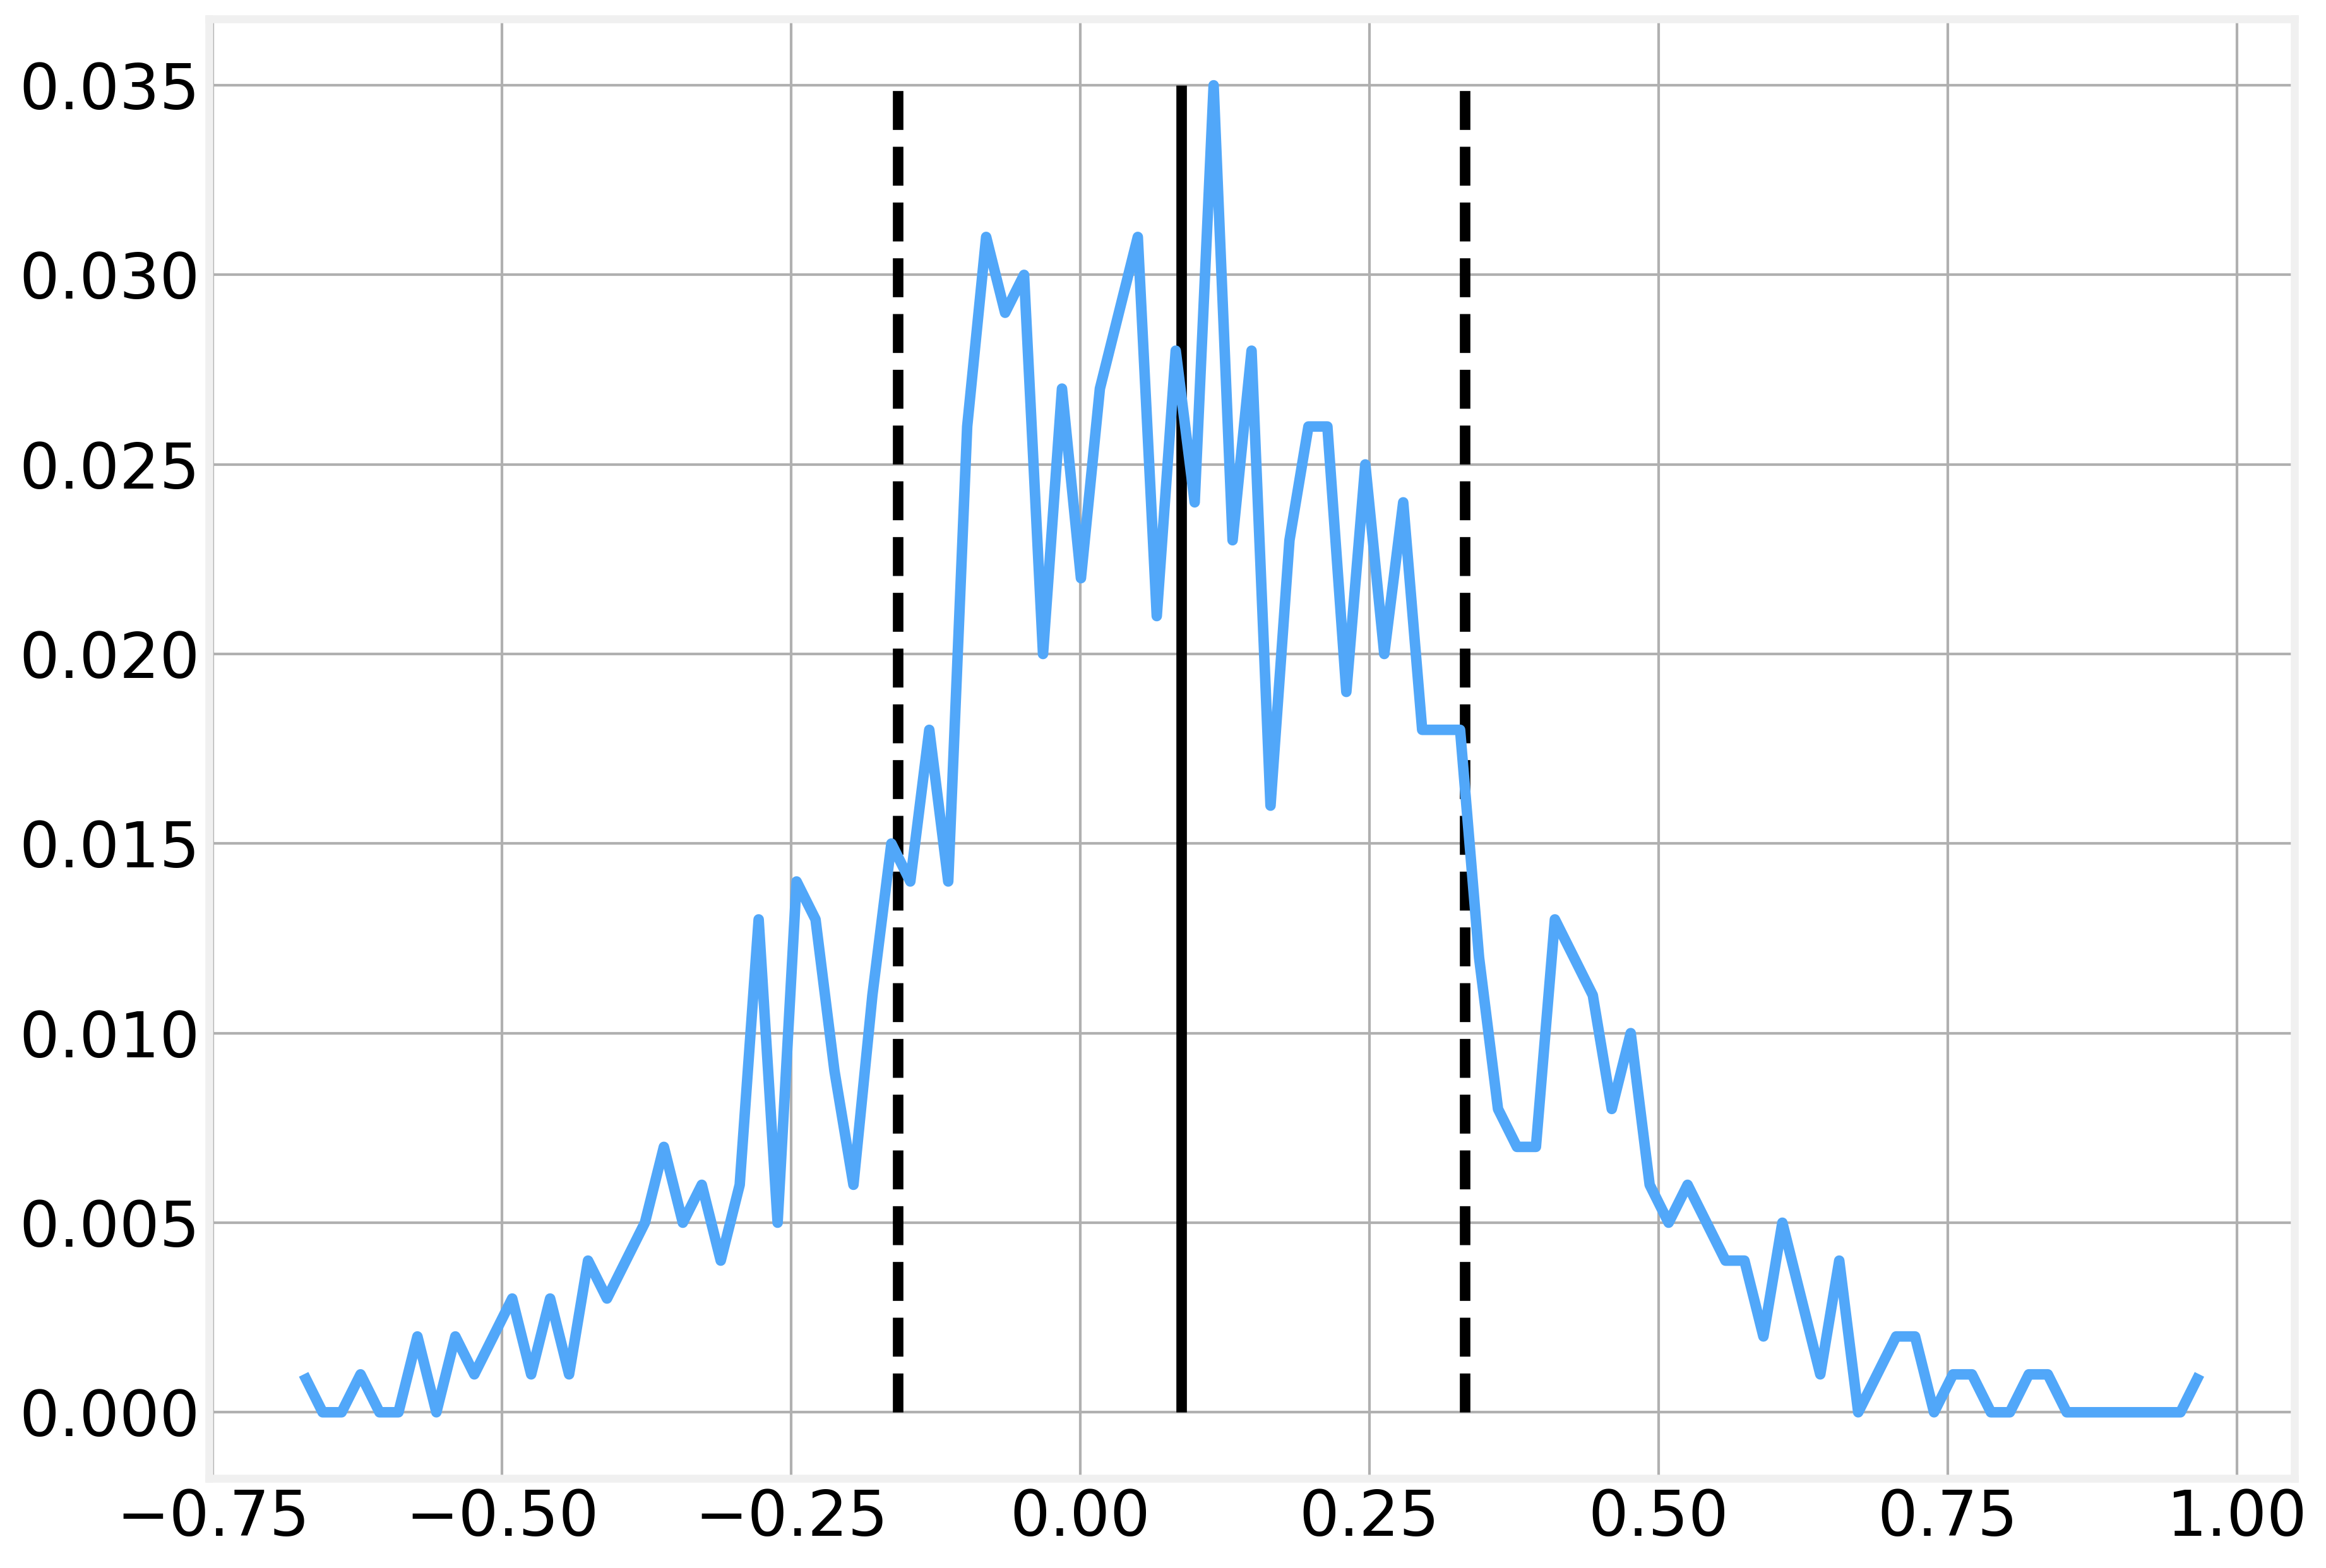

In [44]:
plt.plot(bins, counts)
plt.vlines(x=boot.mean(), ymin=0, ymax=counts.max(), label='mean')
plt.vlines(x=boot.mean()+boot.std(), ymin=0, ymax=counts.max(), label='std', linestyles='--')
plt.vlines(x=boot.mean()-boot.std(), ymin=0, ymax=counts.max(), label='std', linestyles='--')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>